# Time Series II - Generative Approach

In [1]:
import wooldridge as woo
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from supplementaryFunctions import *

## The Nature of Highly Persistent Time Series

### Random Walk Hypothesis

$$y_t = y_{t-1} + e_t$$

$$ y_t = y_0 + e_1 + e_2 + ... + e_{t-1} + e_t $$

$$Var(y_t|y_0) = \sigma_e^2t$$

Data that is a random walk is a function of the value in the previous periods (as opposed to being drawn from a distribution whose mean is defined by a constant or a line. Rather, the new value is drawn from a distribution $E$ wherek $\bar{E}$ is a constant. Below, we assume $\bar{E}=0$.

In [2]:
x_range = np.linspace(0, 100, num = 101)
simulations = {}

for r in range(1000):
    e = stats.norm.rvs(0,1, size = 101)
    e[0] = 0
    simulations[r] = np.cumsum(e)
simulations = pd.DataFrame(simulations)
simulations.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.607120,0.193792,1.054844,0.578313,1.170291,-0.074419,-0.449756,0.426777,-0.246864,0.364389,...,0.137460,-1.050801,-0.520901,0.849680,0.928104,-1.640382,1.057258,-0.734991,0.821270,0.193478
2,0.411572,-0.927125,0.815966,1.233793,0.340847,0.401598,0.332120,1.265944,-1.665124,-0.423933,...,-1.241360,0.554352,1.553820,1.069953,0.970802,-0.224663,-0.926052,-0.153102,-2.577250,-0.529490
3,0.655534,-2.469373,2.184642,-0.045739,-0.500964,-0.538270,0.763621,1.281914,-1.663606,-2.783136,...,-2.671452,0.139576,2.235364,2.609224,1.101175,1.513936,-1.511932,2.162171,-2.437746,0.175815
4,-0.314978,-2.707437,3.678893,0.449236,0.816804,-1.778607,0.522082,1.575655,-0.988279,-1.416024,...,-4.877340,0.066370,1.584514,3.059970,1.941353,-0.108687,-1.004512,3.253238,-4.148061,-0.458557


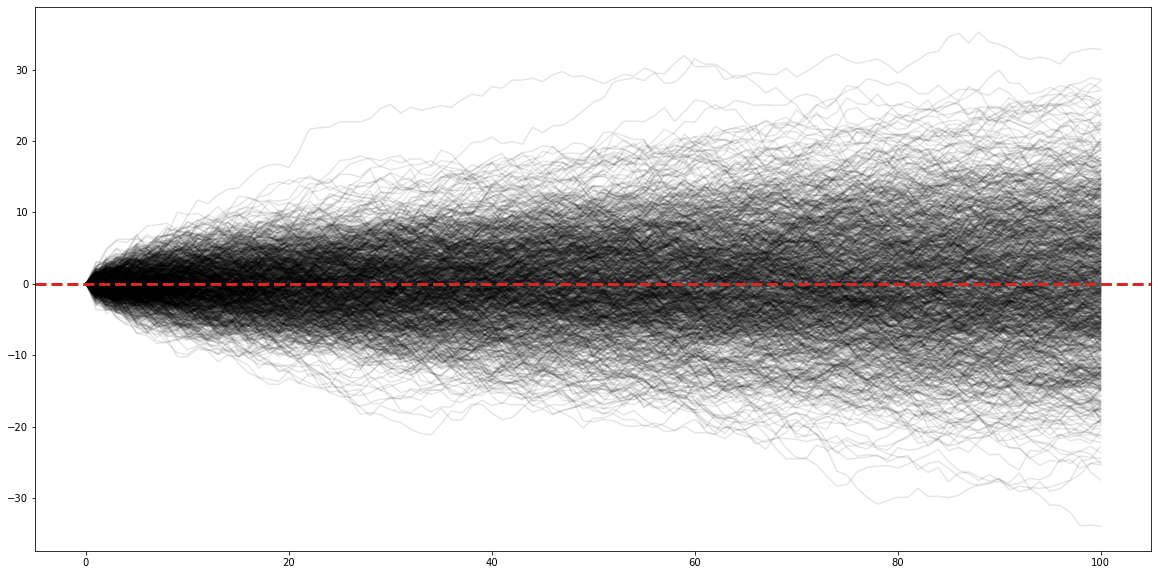

In [3]:
fig, ax = plt.subplots(figsize = (20,10))
simulations.plot.line(alpha = .1, color = "k", ax = ax, legend = False)
ax.axhline(0, ls = "--", color = "C3", linewidth = 3)


### Random Walk with Drift

If that $\bar{E} \ne 0$, the the the function is described as a random walk with drift. We describe $\bar{E}$ as $\alpha_0$.

$$y_t = \alpha_0 + y_{t-1} + e_t$$

$$ y_t = y_0 + \alpha_0t + e_1 + e_2 + ... + e_{t-1} + e_t $$

We can $\bar{E} \ne0$ using OLS regression with a lag. If the value of an observation is simply a function of the past value plus some error, all variation should be explained by the lag term

In [4]:
def monte_carlo_simulation(e_bar = 0, periods = 101, num_simulations = 100):
    x_range = np.linspace(0, periods - 1, 
                          num = periods)
    simulations = {}
    for r in range(num_simulations):
        e = stats.norm.rvs(e_bar, 1, size = periods)
        e[0] = 0
        simulations[r] = np.cumsum(e)
    simulations = pd.DataFrame(simulations)
    return simulations

e_bar = 2
periods = 200
num_simulations = 2000
simulations = monte_carlo_simulation(e_bar = e_bar, 
                                     periods = periods, 
                                     num_simulations = num_simulations)
simulations

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.168415,1.816289,1.165428,4.176329,3.652992,-0.021064,1.908117,1.795349,4.160971,2.329230,...,2.394553,2.950612,1.212546,3.675675,2.033374,2.177470,2.130454,0.926879,1.266284,0.075185
2,3.045617,2.662670,2.388403,7.658891,3.782950,2.188954,5.300198,3.635027,5.700438,4.144543,...,5.359073,4.884155,0.167595,6.477502,3.092128,3.155466,3.645713,1.526154,3.424650,1.677200
3,6.200881,5.026477,5.307417,9.753321,6.260601,4.867519,7.955528,4.787009,7.729789,8.084480,...,9.275578,7.510725,2.448790,9.941096,5.266936,5.761748,5.677269,2.156040,7.592894,4.976853
4,7.821231,7.273897,8.122482,13.337811,9.846222,5.792683,10.510588,8.789545,10.221574,9.474785,...,11.871198,10.340410,3.428795,11.366672,7.067106,7.947749,5.863338,4.482289,9.507058,6.924032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,389.172662,353.146381,387.712295,402.947143,406.927919,393.154691,369.553165,385.718190,386.502881,400.728960,...,374.093165,402.441669,361.105758,378.286832,373.073832,376.269311,374.344639,384.508207,421.748772,377.103478
196,390.410430,355.985400,389.936034,404.704371,409.421564,395.361931,372.132394,386.067667,389.383242,402.707582,...,375.619112,404.951973,360.739075,380.789493,377.219709,377.839883,376.225377,385.605384,423.163490,378.091934
197,393.829127,356.089121,390.457782,408.627668,410.852884,398.396422,373.266423,387.480474,389.681938,405.866843,...,378.291008,405.917925,362.710706,384.341990,377.411688,379.486934,379.213778,388.274061,426.560072,381.628190
198,396.545112,356.942431,392.319282,410.889238,412.304648,399.407002,375.771371,388.356098,391.255789,407.012121,...,380.881016,408.361255,364.755766,384.935228,378.764816,382.975361,380.733434,390.158703,428.891023,384.290299


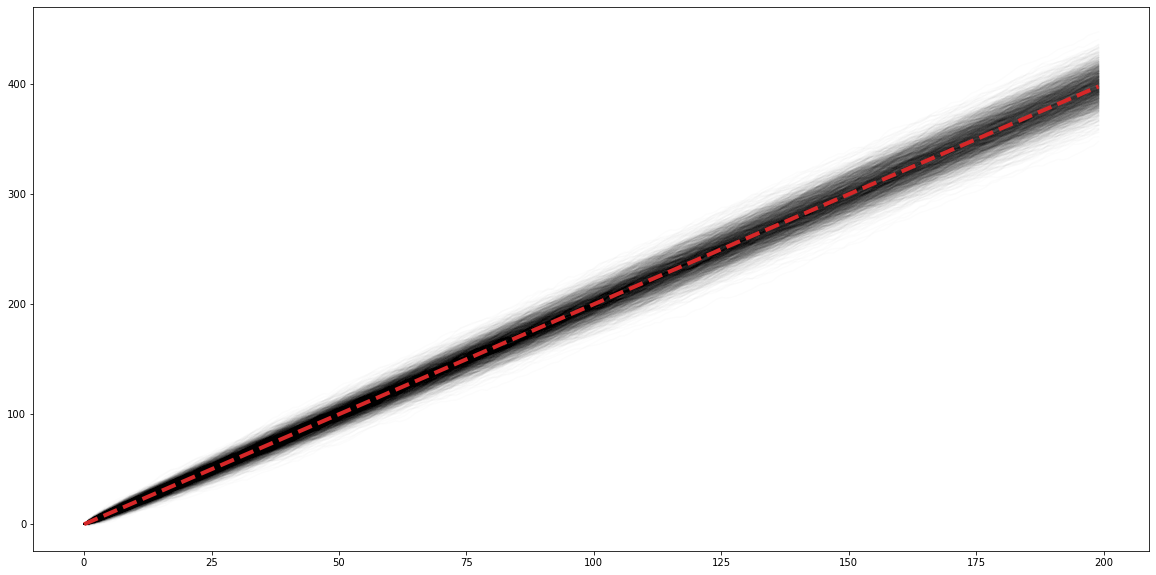

In [5]:
fig, ax = plt.subplots(figsize = (20,10))
simulations.plot.line(alpha = .01, 
                      color = "k", 
                      ax = ax, 
                      legend = False)
ax.plot(np.arange(periods), np.arange(periods) * e_bar, ls = "--", color = "C3", linewidth = 4)


### Unit Root in Artificial Data

In [6]:
simulations.rename(columns = {i:"Simulation" + str(i) for i in simulations.keys()}, inplace = True)
results = {}
for i in simulations:
    formula = i + " ~ " + i + ".shift(1) + 1"
    reg = smf.ols(formula = formula,
        data =simulations)
    results[i] = reg.fit()
    print(OLS_summary(results[i]))


                      $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                             
Intercept               2.2283    14.6260        0.0  0.1523
Simulation0.shift(1)    0.9989  1542.1438        0.0  0.0006
                      $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                             
Intercept               1.5284    10.9497        0.0  0.1396
Simulation1.shift(1)    1.0016  1417.4997        0.0  0.0007
                      $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                             
Intercept               1.9122    13.9766        0.0  0.1368
Simulation2.shift(1)    1.0004  1648.9988        0.0  0.0006
                      $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                             
Intercept               2.1880    16.1567        0.0  0.1354
Simulation3.shift(1)    0.9995  1770.4477        0.0  0.0006
                      $\

                       $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                1.9237    15.3089        0.0  0.1257
Simulation49.shift(1)    1.0002  1777.9416        0.0  0.0006
                       $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                1.9784    14.4092        0.0  0.1373
Simulation50.shift(1)    0.9999  1648.6555        0.0  0.0006
                       $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                2.0650    14.5009        0.0  0.1424
Simulation51.shift(1)    1.0003  1697.6371        0.0  0.0006
                       $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                1.9901    13.9622        0.0  0.1425
Simulation52.shift(1)    0.9996  1553.1210        0.0  0.0006
        

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0608    14.5451        0.0  0.1417
Simulation106.shift(1)    1.0001  1678.2312        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1129    15.8810        0.0  0.1330
Simulation107.shift(1)    0.9998  1775.1118        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8337    13.6219        0.0  0.1346
Simulation108.shift(1)    1.0008  1654.4850        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9543    15.5449        0.0  0.1257
Simulation109.shift(1)    1.0000  1769.1156        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                  2.067    15.4099        0.0  0.1341
Simulation161.shift(1)     1.000  1752.8616        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0256    13.9342        0.0  0.1454
Simulation162.shift(1)    1.0000  1590.4947        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9612    13.0887        0.0  0.1498
Simulation163.shift(1)    1.0002  1522.4265        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9640    14.3112        0.0  0.1372
Simulation164.shift(1)    1.0006  1709.9371        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9506    14.5173        0.0  0.1344
Simulation216.shift(1)    1.0009  1774.7921        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9316    12.1073        0.0  0.1595
Simulation217.shift(1)    1.0000  1380.0767        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1573    14.1220        0.0  0.1528
Simulation218.shift(1)    1.0001  1620.6995        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0170    14.1091        0.0  0.1430
Simulation219.shift(1)    1.0001  1609.7939        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8768    13.6258        0.0  0.1377
Simulation273.shift(1)    1.0002  1580.5467        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1694    13.6707        0.0  0.1587
Simulation274.shift(1)    0.9990  1454.4390        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0812    14.0559        0.0  0.1481
Simulation275.shift(1)    0.9999  1593.9156        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0183    12.5132        0.0  0.1613
Simulation276.shift(1)    1.0002  1452.0425        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.7952    11.9616        0.0  0.1501
Simulation329.shift(1)    1.0012  1489.2344        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9197    13.2877        0.0  0.1445
Simulation330.shift(1)    1.0003  1552.3527        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1020    15.2705        0.0  0.1376
Simulation331.shift(1)    1.0001  1746.5993        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9341    13.1956        0.0  0.1466
Simulation332.shift(1)    0.9998  1481.2201        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1639    15.7215        0.0  0.1376
Simulation385.shift(1)    0.9991  1681.7115        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0712    14.1143        0.0  0.1467
Simulation386.shift(1)    1.0000  1614.8679        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2414    15.3445        0.0  0.1461
Simulation387.shift(1)    0.9993  1666.1671        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0169    16.4727        0.0  0.1224
Simulation388.shift(1)    0.9998  1857.0490        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0026    14.9265        0.0  0.1342
Simulation440.shift(1)    0.9994  1632.9009        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8834    14.3261        0.0  0.1315
Simulation441.shift(1)    0.9999  1632.6423        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0920    14.5914        0.0  0.1434
Simulation442.shift(1)    0.9998  1634.8452        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0398    14.9673        0.0  0.1363
Simulation443.shift(1)    0.9997  1677.7700        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1648    15.8889        0.0  0.1362
Simulation497.shift(1)    0.9990  1697.4567        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8192    12.6759        0.0  0.1435
Simulation498.shift(1)    1.0008  1538.6207        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0154    14.4408        0.0  0.1396
Simulation499.shift(1)    1.0002  1671.0397        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2977    16.8869        0.0  0.1361
Simulation500.shift(1)    0.9987  1774.6445        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0165    14.2268        0.0  0.1417
Simulation550.shift(1)    0.9997  1602.1780        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2104    15.4803        0.0  0.1428
Simulation551.shift(1)    0.9992  1671.7924        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9571    15.5832        0.0  0.1256
Simulation552.shift(1)    1.0004  1830.7011        0.0  0.0005
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1586    13.8153        0.0  0.1562
Simulation553.shift(1)    0.9996  1524.9663        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8303    14.1689        0.0  0.1292
Simulation603.shift(1)    1.0001  1625.7620        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9465    13.0686        0.0  0.1489
Simulation604.shift(1)    1.0003  1514.8601        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9612    13.2962        0.0  0.1475
Simulation605.shift(1)    0.9998  1498.8297        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9617    13.5284        0.0  0.1450
Simulation606.shift(1)    1.0003  1587.5720        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9483    13.9174        0.0  0.1400
Simulation645.shift(1)    1.0001  1595.3560        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0121    15.5052        0.0  0.1298
Simulation646.shift(1)    1.0002  1809.3824        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0630    13.4504        0.0  0.1534
Simulation647.shift(1)    0.9995  1487.3833        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0990    15.1065        0.0  0.1389
Simulation648.shift(1)    0.9997  1676.7054        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2158    15.7253        0.0  0.1409
Simulation700.shift(1)    0.9993  1726.4891        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9834    15.6334        0.0  0.1269
Simulation701.shift(1)    1.0005  1856.3497        0.0  0.0005
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0661    13.9858        0.0  0.1477
Simulation702.shift(1)    1.0002  1614.8302        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                  1.814    13.2255        0.0  0.1372
Simulation703.shift(1)     1.001  1637.5690        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9112    12.5847        0.0  0.1519
Simulation752.shift(1)    1.0004  1487.7652        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0619    13.5136        0.0  0.1526
Simulation753.shift(1)    0.9997  1514.5721        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9235    13.0132        0.0  0.1478
Simulation754.shift(1)    1.0007  1578.9687        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0283    15.2782        0.0  0.1328
Simulation755.shift(1)    1.0001  1758.9283        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9142    14.1891        0.0  0.1349
Simulation803.shift(1)    1.0002  1658.9562        0.0  0.0006
                        $\beta $       $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                 2.0341    15.594        0.0  0.1304
Simulation804.shift(1)    1.0000  1779.898        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0028    15.0135        0.0  0.1334
Simulation805.shift(1)    0.9998  1686.0282        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9564    13.5369        0.0  0.1445
Simulation806.shift(1)    0.9995  1490.4516        0.0  0.0

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0525    14.0616        0.0  0.1460
Simulation862.shift(1)    0.9996  1562.0052        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0489    15.8366        0.0  0.1294
Simulation863.shift(1)    1.0002  1846.4889        0.0  0.0005
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2693    15.3083        0.0  0.1482
Simulation864.shift(1)    0.9985  1574.1536        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0990    15.1179        0.0  0.1388
Simulation865.shift(1)    0.9997  1688.0697        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9484    13.3999        0.0  0.1454
Simulation915.shift(1)    1.0002  1542.0914        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9366    13.2823        0.0  0.1458
Simulation916.shift(1)    1.0001  1527.5798        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9983    13.8506        0.0  0.1443
Simulation917.shift(1)    1.0000  1591.0821        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8859    12.4723        0.0  0.1512
Simulation918.shift(1)    1.0003  1471.4146        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1525    14.9015        0.0  0.1445
Simulation970.shift(1)    0.9995  1639.2905        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0387    13.2266        0.0  0.1541
Simulation971.shift(1)    0.9999  1502.1506        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0901    13.6154        0.0  0.1535
Simulation972.shift(1)    0.9999  1549.7145        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1391    15.7263        0.0  0.1360
Simulation973.shift(1)    0.9998  1779.4696        0.0 

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0617    14.0417        0.0  0.1468
Simulation1028.shift(1)    1.0000  1601.9280        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.7079    11.6719        0.0  0.1463
Simulation1029.shift(1)    1.0011  1446.2836        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1917    15.0746        0.0  0.1454
Simulation1030.shift(1)    0.9997  1674.1377        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1487    15.7971        0.0  0.1360
Simulation1031.shift(1)    0.9991  1695.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8418    13.2860        0.0  0.1386
Simulation1082.shift(1)    1.0009  1628.2409        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.4152    16.0456        0.0  0.1505
Simulation1083.shift(1)    0.9984  1622.9213        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1382    16.1436        0.0  0.1325
Simulation1084.shift(1)    1.0001  1855.9118        0.0  0.0005
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1311    15.4857        0.0  0.1376
Simulation1085.shift(1)    0.9996  1725.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9109    13.5834        0.0  0.1407
Simulation1134.shift(1)    1.0004  1606.4456        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1323    15.5252        0.0  0.1373
Simulation1135.shift(1)    0.9999  1765.1998        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.3083    16.7439        0.0  0.1379
Simulation1136.shift(1)    0.9994  1839.2405        0.0  0.0005
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0319    14.7979        0.0  0.1373
Simulation1137.shift(1)    1.0005  1763.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0162    13.2786        0.0  0.1518
Simulation1188.shift(1)    0.9999  1511.5750        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2082    17.2571        0.0  0.1280
Simulation1189.shift(1)    0.9991  1860.4818        0.0  0.0005
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2444    15.9219        0.0  0.1410
Simulation1190.shift(1)    0.9989  1685.8359        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9051    14.4860        0.0  0.1315
Simulation1191.shift(1)    1.0002  1686.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9328    13.6698        0.0  0.1414
Simulation1243.shift(1)    1.0002  1597.2496        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9946    14.5718        0.0  0.1369
Simulation1244.shift(1)    1.0000  1679.4165        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.7538    13.9983        0.0  0.1253
Simulation1245.shift(1)    1.0016  1806.4645        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0517    14.9904        0.0  0.1369
Simulation1246.shift(1)    1.0001  1728.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0233    15.3255        0.0  0.1320
Simulation1300.shift(1)    1.0001  1755.0862        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.7738    13.4079        0.0  0.1323
Simulation1301.shift(1)    1.0012  1687.7527        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1242    13.7922        0.0  0.1540
Simulation1302.shift(1)    0.9997  1533.2374        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9686    14.0243        0.0  0.1404
Simulation1303.shift(1)    0.9996  1565.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.6792    11.5233        0.0  0.1457
Simulation1356.shift(1)    1.0019  1526.1682        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1891    16.4622        0.0  0.1330
Simulation1357.shift(1)    0.9993  1786.4380        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8337    13.4746        0.0  0.1361
Simulation1358.shift(1)    1.0007  1620.3417        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9086    13.0591        0.0  0.1462
Simulation1359.shift(1)    1.0007  1571.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0132    14.4188        0.0  0.1396
Simulation1412.shift(1)    1.0003  1681.5234        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2423    15.3496        0.0  0.1461
Simulation1413.shift(1)    0.9990  1623.7147        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0519    14.9038        0.0  0.1377
Simulation1414.shift(1)    0.9999  1686.7100        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.3190    16.4050        0.0  0.1414
Simulation1415.shift(1)    0.9993  1764.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0313    14.0121        0.0  0.1450
Simulation1465.shift(1)    1.0001  1607.9315        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0636    15.4616        0.0  0.1335
Simulation1466.shift(1)    0.9998  1745.3903        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1123    15.4015        0.0  0.1371
Simulation1467.shift(1)    0.9994  1689.8255        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1630    15.1835        0.0  0.1425
Simulation1468.shift(1)    0.9997  1699.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9766    14.1340        0.0  0.1398
Simulation1520.shift(1)    0.9995  1566.9516        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.7934    12.3845        0.0  0.1448
Simulation1521.shift(1)    1.0008  1509.3451        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1079    14.2087        0.0  0.1483
Simulation1522.shift(1)    0.9997  1588.5369        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0079    14.8788        0.0  0.1350
Simulation1523.shift(1)    1.0002  1730.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9221    12.8042        0.0  0.1501
Simulation1577.shift(1)    1.0004  1513.7667        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9089    15.1881        0.0  0.1257
Simulation1578.shift(1)    1.0004  1797.6436        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0486    15.3031        0.0  0.1339
Simulation1579.shift(1)    0.9999  1751.0506        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8369    12.9597        0.0  0.1417
Simulation1580.shift(1)    1.0006  1552.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.7754    13.5877        0.0  0.1307
Simulation1633.shift(1)    1.0009  1665.4175        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1143    16.4831        0.0  0.1283
Simulation1634.shift(1)    0.9995  1814.1568        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0603    14.1786        0.0  0.1453
Simulation1635.shift(1)    1.0002  1635.7493        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0294    13.1294        0.0  0.1546
Simulation1636.shift(1)    1.0000  1503.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0511    13.1285        0.0  0.1562
Simulation1690.shift(1)    0.9993  1420.0849        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8796    14.2422        0.0  0.1320
Simulation1691.shift(1)    1.0001  1638.6748        0.0  0.0006
                         $\beta $       $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                  1.7598    13.638        0.0  0.1290
Simulation1692.shift(1)    1.0012  1719.490        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0285    14.4432        0.0  0.1404
Simulation1693.shift(1)    1.0002  1673.6513

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.4125    16.9018        0.0  0.1427
Simulation1748.shift(1)    0.9979  1665.4721        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9019    13.5174        0.0  0.1407
Simulation1749.shift(1)    1.0000  1545.2443        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2498    15.9842        0.0  0.1408
Simulation1750.shift(1)    0.9989  1697.1778        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0454    13.6015        0.0  0.1504
Simulation1751.shift(1)    0.9998  1533.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0864    14.1630        0.0  0.1473
Simulation1805.shift(1)    0.9995  1561.7301        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1169    13.9612        0.0  0.1516
Simulation1806.shift(1)    0.9998  1573.1947        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2426    14.2747        0.0  0.1571
Simulation1807.shift(1)    0.9989  1519.8637        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8717    14.6469        0.0  0.1278
Simulation1808.shift(1)    1.0005  1743.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1610    16.0058        0.0  0.1350
Simulation1861.shift(1)    0.9994  1762.7446        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9025    14.8288        0.0  0.1283
Simulation1862.shift(1)    1.0007  1794.4358        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0040    13.5911        0.0  0.1474
Simulation1863.shift(1)    0.9998  1529.6839        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0444    15.6924        0.0  0.1303
Simulation1864.shift(1)    1.0002  1826.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9310    13.8780        0.0  0.1391
Simulation1917.shift(1)    0.9998  1571.9407        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9896    14.3881        0.0  0.1383
Simulation1918.shift(1)    1.0002  1659.1296        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9293    14.1818        0.0  0.1360
Simulation1919.shift(1)    1.0003  1666.9915        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8804    14.3921        0.0  0.1307
Simulation1920.shift(1)    1.0006  1728.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9344    13.3395        0.0  0.1450
Simulation1973.shift(1)    0.9994  1457.8221        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9505    14.4784        0.0  0.1347
Simulation1974.shift(1)    1.0001  1670.8516        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1356    14.5557        0.0  0.1467
Simulation1975.shift(1)    0.9995  1598.0337        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9948    14.1864        0.0  0.1406
Simulation1976.shift(1)    0.9998  1593.

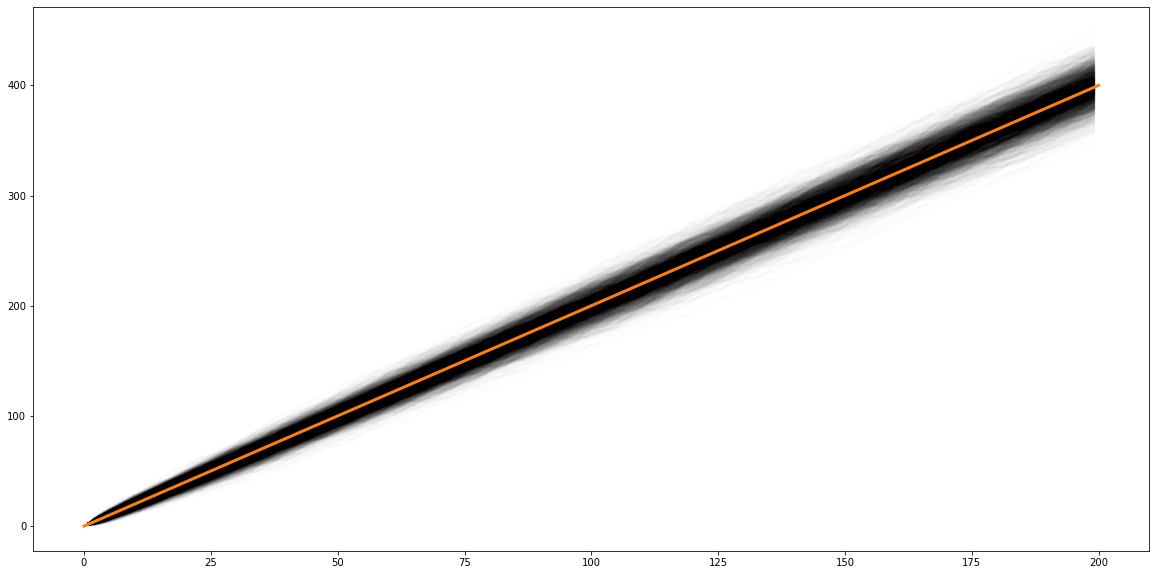

In [7]:
fig, ax = plt.subplots(figsize = (20,10))
for i in simulations:   
    data = simulations[[i]][1:]
    data["Predictor"] = results[i].predict()
    data["Predictor"].plot.line(color = "k", alpha = .01, linewidth = 3, ls = "-", ax = ax)#, label = "y-hat")
    #     x = np.linspace(list(simulations[i].index).iloc[0]), list(simulations[i].index).iloc[-1], periods - 1)
#     y = val["Intercept"] + val[i + ".shift(1)"] * x
#     ax.plot(x, y, color = "k", alpha = .01, linewidth = 3, ls = "-")#, label = "y-hat")
x = np.linspace(0, periods, periods)
y = 0 + e_bar * x
ax.plot(x,y, color = "C1", linewidth = 3)


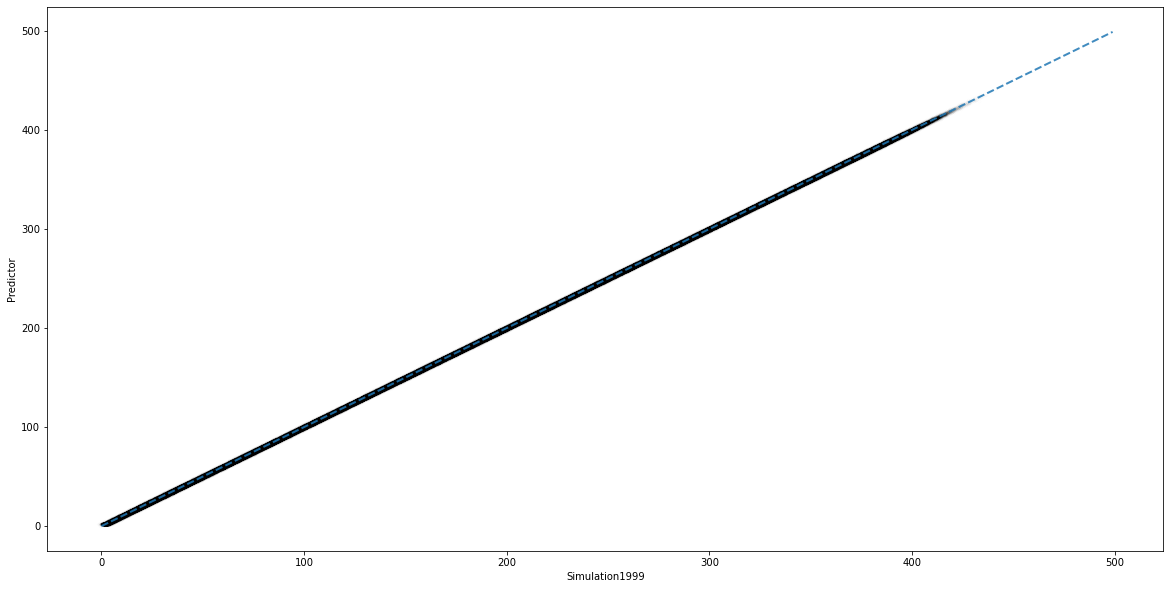

In [8]:
fig, ax = plt.subplots(figsize = (20,10))
for i in simulations:   
    data = simulations[[i]][1:]
    data["Predictor"] = results[i].predict()
    data.plot.scatter(x = i, y = "Predictor", alpha = .005, s = 10, ax = ax, color = "k")
ax.plot(np.arange(max(ax.get_xticks())), linewidth = 2, ls = "--", alpha = .85)

## Differences of Highly Persistent Time Series


In [9]:
sim_diff = simulations.diff().dropna()
sim_diff

,Simulation0,Simulation1,Simulation2,Simulation3,Simulation4,Simulation5,Simulation6,Simulation7,Simulation8,Simulation9,...,Simulation1990,Simulation1991,Simulation1992,Simulation1993,Simulation1994,Simulation1995,Simulation1996,Simulation1997,Simulation1998,Simulation1999
1,3.168415,1.816289,1.165428,4.176329,3.652992,-0.021064,1.908117,1.795349,4.160971,2.329230,...,2.394553,2.950612,1.212546,3.675675,2.033374,2.177470,2.130454,0.926879,1.266284,0.075185
2,-0.122798,0.846381,1.222975,3.482562,0.129958,2.210018,3.392081,1.839678,1.539466,1.815313,...,2.964520,1.933543,-1.044951,2.801827,1.058754,0.977995,1.515259,0.599274,2.158366,1.602016
3,3.155263,2.363807,2.919014,2.094430,2.477650,2.678565,2.655329,1.151983,2.029351,3.939937,...,3.916505,2.626570,2.281195,3.463594,2.174808,2.606282,2.031556,0.629887,4.168244,3.299653
4,1.620350,2.247420,2.815065,3.584491,3.585622,0.925165,2.555061,4.002535,2.491785,1.390305,...,2.595620,2.829685,0.980004,1.425576,1.800170,2.186001,0.186069,2.326248,1.914163,1.947179
5,3.630127,0.940452,2.788160,1.364779,0.379975,0.788755,2.611634,3.367641,2.153143,1.812779,...,2.910632,1.393776,1.151236,3.736697,3.696890,2.648470,3.772897,2.041015,2.905234,2.451949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.506603,2.463550,2.160737,2.252790,2.528614,1.239783,1.987344,0.785149,0.415043,2.736952,...,3.222077,3.424599,2.102145,1.733799,1.783564,4.390500,2.030328,3.871493,0.986845,3.531578
196,1.237767,2.839018,2.223739,1.757228,2.493645,2.207240,2.579229,0.349477,2.880361,1.978622,...,1.525947,2.510304,-0.366683,2.502661,4.145877,1.570571,1.880737,1.097177,1.414719,0.988455
197,3.418697,0.103721,0.521748,3.923297,1.431320,3.034492,1.134029,1.412807,0.298696,3.159261,...,2.671896,0.965952,1.971631,3.552498,0.191979,1.647051,2.988401,2.668677,3.396581,3.536256
198,2.715986,0.853310,1.861501,2.261570,1.451764,1.010579,2.504948,0.875624,1.573851,1.145278,...,2.590007,2.443331,2.045060,0.593237,1.353128,3.488427,1.519656,1.884642,2.330951,2.662109


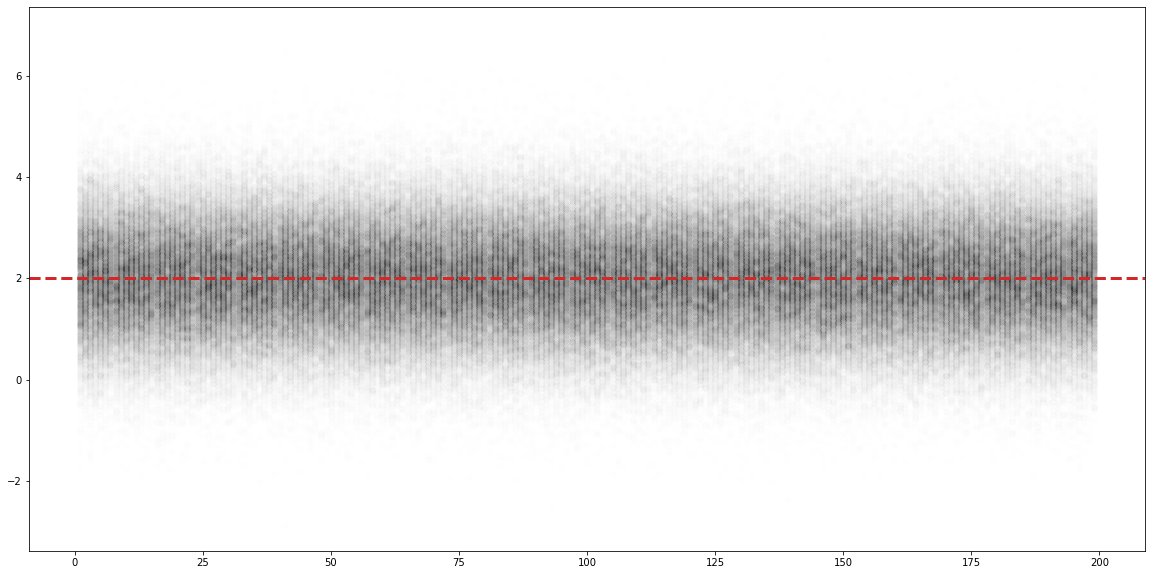

In [10]:
fig, ax = plt.subplots(figsize = (20,10))
sim_diff.plot.line(alpha = .002,
                             ls = " ",
                             marker = "o",
                             markersize = 6,
                             color = "k",
                      ax = ax, 
                      legend = False)
ax.axhline(e_bar, ls = "--", color = "C3", linewidth = 3)


In [11]:
count_sig = 0
p_val = 0.05
for i in sim_diff:
    formula = i + " ~ " + i + ".shift(1) + 1"
    reg = smf.ols(formula = formula,
        data =sim_diff)
    results[i] = reg.fit()
    summary = OLS_summary(results[i])
    if summary.iloc[1]["$$P>|t|$$"] <= p_val:
        count_sig += 1 

# compare number of statistically significant estimates to the asserted p_val
count_sig / len(sim_diff.keys())

0.0435

In [12]:
count_sig

87

### Testing for Serial Correlation: Testing Phillip Curve for Reversion to Natural Rate (Mean Reversion)

#### Regress lag of error against error

$$\hat{u_t} = \hat{\rho}\hat{u_{t-1}}+ k$$

In [13]:
phillips = woo.dataWoo("phillips")
periods = len(phillips.index)

# define yearly time series index
pd.to_datetime(phillips["year"])
phillips.set_index("year", inplace = True)
yt96 = phillips.index <= 1996
formula = "Q('inf') ~ unem"
reg_s = smf.ols(formula = formula,
               data = phillips,
               subset = yt96)
results_s = reg_s.fit()
OLS_summary(results_s)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.0527$$,,,,
Intercept,1.4236,0.8282,0.4118,1.7190
unem,0.4676,1.6174,0.1125,0.2891


['Intercept', 'unem']
Q('inf')


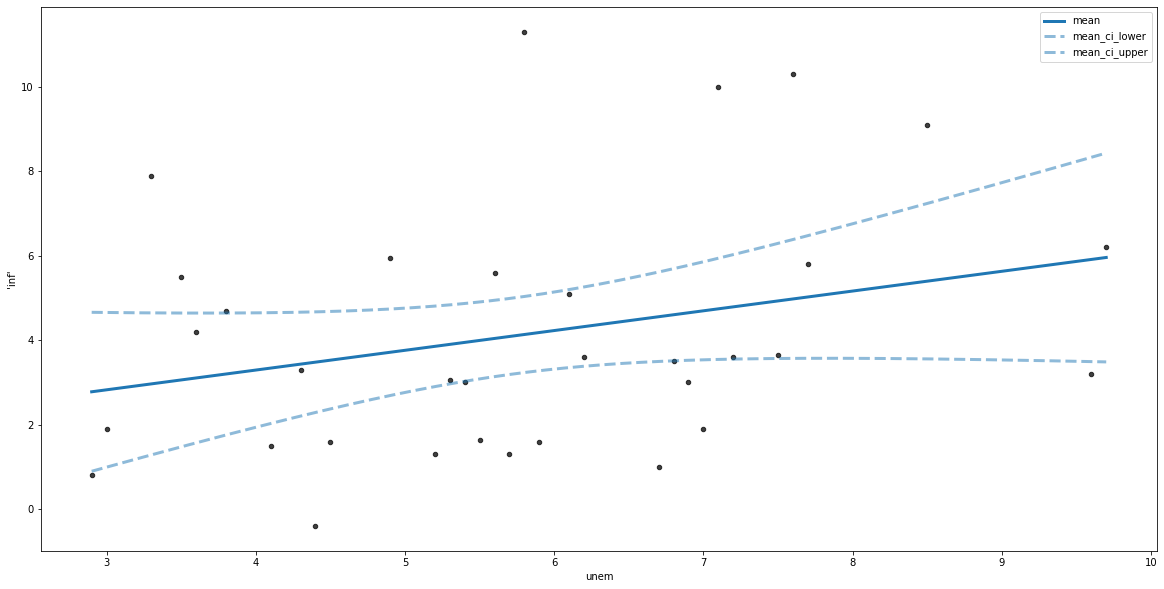

In [14]:
build_estimator(phillips, results_s, "Q('inf')")
build_smooth_multiple_regression_estimator(reg_s, phillips)

In [15]:
# residuals and AR(1) test:
phillips["resid_s"] = results_s.resid
phillips["resid_s_lag1"] = phillips["resid_s"].shift() 
reg_df = phillips[["resid_s", "resid_s_lag1"]]
formula = "resid_s ~ resid_s_lag1 + 0"
reg = smf.ols(formula = formula,
             data = reg_df,
             subset = yt96)
results = reg.fit()
# for bivariate regression, the squareroot of r-squared 
# is the correlation between the variables 

print(round(results.rsquared ** .5,3), reg_df.corr().round(3).iloc[0][1])
OLS_summary(results)

0.588 0.588


,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.3454$$,,,,
resid_s_lag1,0.5727,4.9797,0.0,0.115


#### According to the t-statistic for $\hat{\rho}$, the estimated error term is serially correlated. 

#### We can also check the Durbin-Watson Statistic:

$$DW = \frac{\sum_{t=2}^{n}{(\hat{u}_t - \hat{u}_{t-1})^2}}{\sum_{t=1}^{n}{\hat{u}_t^2}}$$

In [16]:
sm.stats.stattools.durbin_watson(results_s.resid)

0.802700467848626

In [17]:
sm.stats.diagnostic.acorr_breusch_godfrey(results, nlags = 1)

(5.356006336085807,
 0.020651013085524358,
 5.651911880721935,
 0.021747051510411165)

['resid_s_lag1']
resid_s


C:\Users\JLCat\GithubRepositories\Learn-Python-for-Stats-and-Econ\Projects\Graduate Macro Notebooks\supplementaryFunctions.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["$$\widehat{" + y_name + "}$$"] = results.fittedvalues
C:\Users\JLCat\GithubRepositories\Learn-Python-for-Stats-and-Econ\Projects\Graduate Macro Notebooks\supplementaryFunctions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["$$\hat{u}$$"] = results.resid


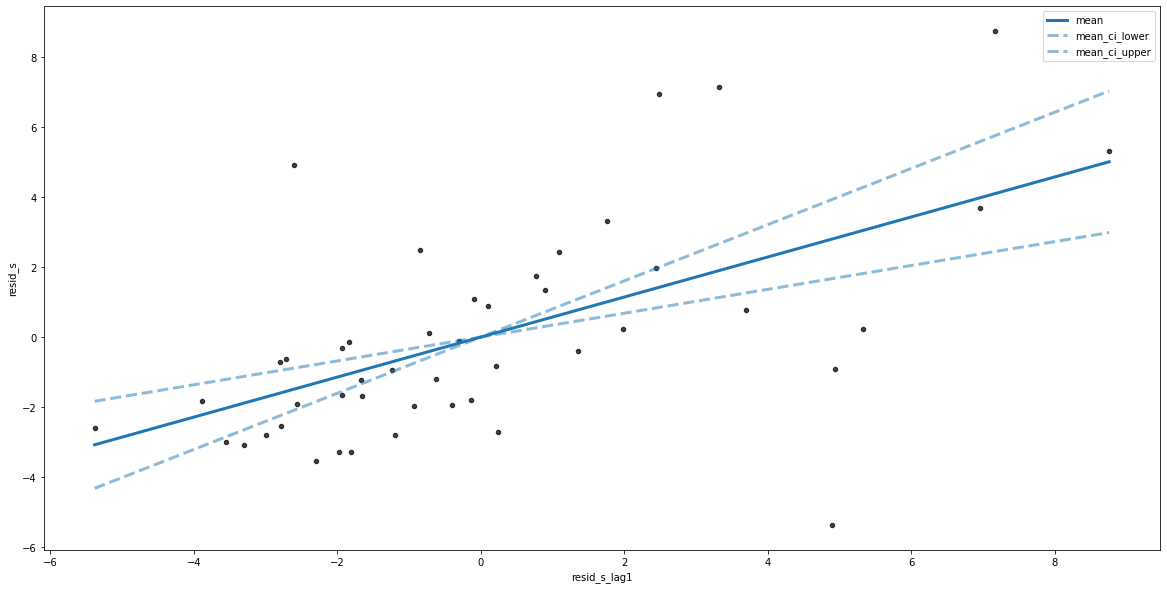

In [18]:
build_estimator(reg_df, results_s, "resid_s")
build_smooth_multiple_regression_estimator(reg, reg_df)

In [19]:
# probably most accurate model

formula = "unem ~ Q('inf') + 1"
reg_s = smf.ols(formula = formula,
               data = phillips.diff(),
               subset = yt96)
results_s = reg_s.fit()
OLS_summary(results_s)


,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.135$$,,,,
Intercept,0.0163,0.1071,0.9152,0.1521
Q('inf'),-0.1604,-2.6799,0.0102,0.0598


In [20]:
# probably most accurate model

formula = "unem ~ Q('inf') + Q('inf').shift() + 0"
reg_s = smf.ols(formula = formula,
               data = phillips.diff(),
               subset = yt96)
results_s = reg_s.fit()
OLS_summary(results_s)


,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.1351$$,,,,
Q('inf'),-0.1338,-1.9538,0.0570,0.0685
Q('inf').shift(),0.1027,1.7659,0.0842,0.0582


In [21]:
hac_results = reg_s.fit(cov_type="HAC", cov_kwds={"maxlags":1})
OLS_summary(hac_results)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.1351$$,,,,
Q('inf'),-0.1338,-2.2195,0.0265,0.0603
Q('inf').shift(),0.1027,1.3189,0.1872,0.0779


In [22]:
# residuals and AR(1) test:
phillips["resid_s"] = results_s.resid
phillips["resid_s_lag1"] = phillips["resid_s"].shift() 
formula = "resid_s ~ resid_s_lag1"
reg = smf.ols(formula = formula,
             data = phillips,
             subset = yt96)
results = reg.fit()
OLS_summary(results)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.0016$$,,,,
Intercept,-0.0011,-0.0073,0.9942,0.1519
resid_s_lag1,-0.0402,-0.2682,0.7898,0.1500
